In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from modelling_functions import (
    LSTMModel,
    LinearModel,
    prepare_dataloaders,
    load_and_preprocess_data,
    evaluate_anomalies,
    load_data,
)


from eda_helper import (
    get_custom_palette,
    get_custom_heatmap,
    get_custom_colormap,
    plot_mv_windows,
    preprocess_data,
    extract_values_from_filename,
)

custom_palette = get_custom_palette()
custom_heatmap = get_custom_heatmap()
custom_colormap = get_custom_colormap()

print(os.getcwd())

completeness_value = 1
input_feature_indices = [0]  # list(range(0, 11))
target_feature_index = 0
horizon = 6
window_size = 48
batch_size = 8
stride = 1
model_type = "Multivariate" if len(input_feature_indices) > 1 else "Univariate"
device = "cpu"

c:\#code\#python\#current\mres-project\analysis_files


In [2]:
# east_df, _ = load_data()
# east_dict = preprocess_data(east_df, completeness_value)

# data, columns, index = east_dict["data"], east_dict["columns"], east_dict["index"]

In [3]:
east_timeseries = load_and_preprocess_data(completeness_value)
data = east_timeseries

Removing incomplete days...
Initial number of records: 39904
Number of records in days @ 100% completeness: 15744
Proportion of records removed: 60.55%
Maximum consecutive days: 9
Starting from day number 205 in 2022


In [4]:
(
    train_dataloader,
    test_dataloader,
    test_inputs,
    test_targets,
    train_inputs,
    train_targets,
) = prepare_dataloaders(
    data=data,
    window_size=window_size,
    input_feature_indices=input_feature_indices,
    target_feature_index=target_feature_index,
    horizon=horizon,
    stride=stride,
    batch_size=batch_size,
    shuffle=False,
)

In [5]:
for X, y in train_dataloader:
    X = X.float().to("cpu")
    y = y.float().to("cpu")
    print(X.shape)
    print(y.shape)
    break

torch.Size([8, 48, 1])
torch.Size([8])


In [6]:
# Selected models currently come from different hyperparameter tests for UV and MV
if len(input_feature_indices) > 1:
    model_folder_path = "C:\\#code\\#python\\#current\\mres-project\\analysis_files\\mv_model_states\\c10959080\\"
    lstm_model_file_name = "LSTM_TestNumber195_Completeness0.95_SequenceLength2576_Horizon6_WindowSize48.pt"
    linear_model_file_name = "Linear_TestNumber195_Completeness0.95_SequenceLength2576_Horizon6_WindowSize48.pt"
else:
    model_folder_path = "C:\\#code\\#python\\#current\\mres-project\\analysis_files\\uv_model_states\\c10989694"
    lstm_model_file_name = "LSTM_TestNumber209_Completeness0.98_SequenceLength2776_Horizon6_WindowSize48.pt"
    linear_model_file_name = "Linear_TestNumber204_Completeness0.98_SequenceLength2776_Horizon6_WindowSize1.pt"

for model_file in os.listdir(model_folder_path):
    # Ensure it's a .pt file (PyTorch model state file)
    if not model_file.endswith(".pt"):
        continue

lstm_model_path = os.path.join(model_folder_path, lstm_model_file_name)

linear_model_path = os.path.join(model_folder_path, linear_model_file_name)

lstm_values = extract_values_from_filename(lstm_model_path)
sequence_length_value = lstm_values["SequenceLength"]
horizon_value = lstm_values["Horizon"]
window_size_value = lstm_values["WindowSize"]
model_completeness_value = lstm_values["Completeness"]
test_number = lstm_values["TestNumber"]

linear_values = extract_values_from_filename(lstm_model_path)
sequence_length_value = linear_values["SequenceLength"]
horizon_value = linear_values["Horizon"]
window_size_value = linear_values["WindowSize"]
model_completeness_value = linear_values["Completeness"]
test_number = linear_values["TestNumber"]

In [7]:
def load_model_with_state_dict(model_folder_path, model_file, input_feature_indices):
    state_path = os.path.join(model_folder_path, model_file)
    if model_file.startswith("Linear"):
        model = LinearModel(input_size=len(input_feature_indices))
        model.load_state_dict(torch.load(state_path))
        model.to(device)
    else:
        model = LSTMModel(feature_dim=len(input_feature_indices))
        model.load_state_dict(torch.load(state_path))
        model.to(device)
    return model


model_file = lstm_model_file_name
model = load_model_with_state_dict(model_folder_path, model_file, input_feature_indices)

648 648 648
(3, 48, 1) (3,) (3, 1)


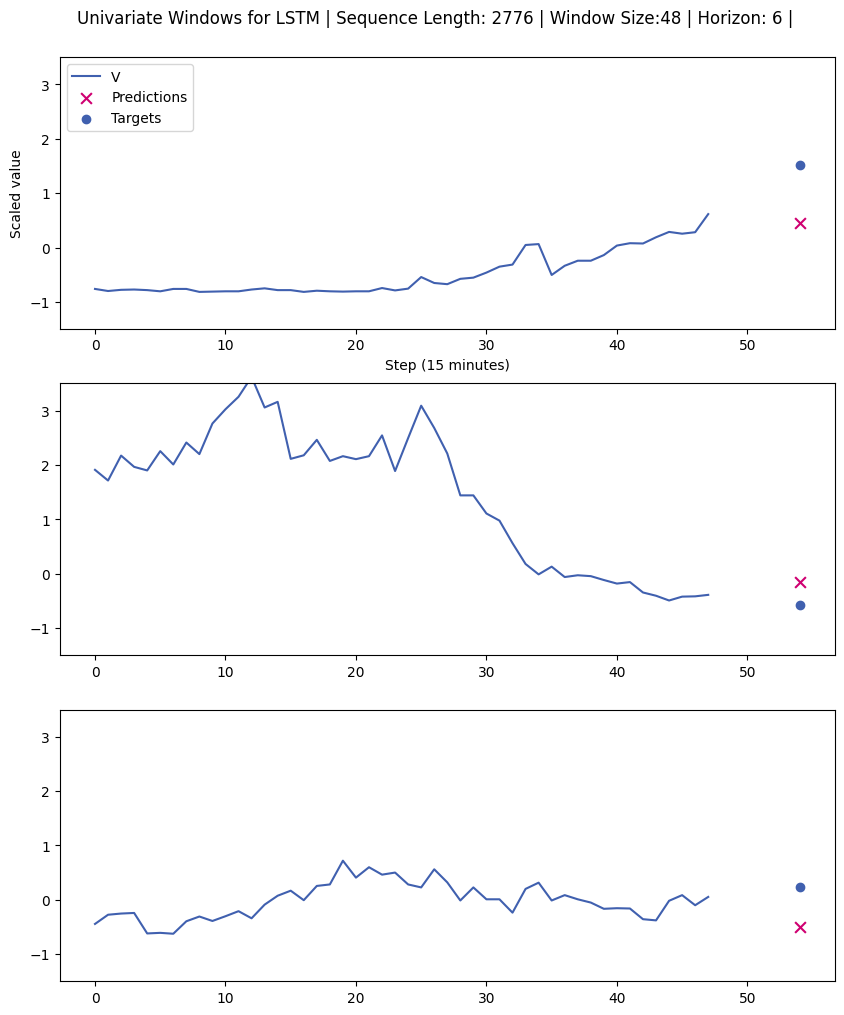

In [8]:
feature_names = [
    "Value",
    "Newcastle term",
    "Northumbria term",
    "Sin day",
    "Cos day",
    "Sin half day",
    "Cos half day",
    "Sin quarter",
    "Cos quarter",
    "Sin year",
    "Cos year",
]

num_plots = 3

# First, gather all the data from the DataLoader
all_inputs = []
all_targets = []
all_predictions = []

for X, y in train_dataloader:
    X = X.float().to(device)
    with torch.inference_mode():
        y_hat = model(X)
    X = X[:, :, [0, 1, 2, 3, 5, 7, 9]] if len(input_feature_indices) > 1 else X
    all_inputs.extend(X.numpy())
    all_targets.extend(y.numpy())
    all_predictions.extend(y_hat.numpy())

print(len(all_inputs), len(all_targets), len(all_predictions))

# Convert lists to numpy arrays
all_inputs = np.array(all_inputs)
all_targets = np.array(all_targets)
all_predictions = np.array(all_predictions)
feature_names = (
    [feature_names[i] for i in [0, 1, 2, 3, 5, 7, 9]]
    if len(input_feature_indices) > 1
    else ["Value"]
)

# Ensure we have enough data
if len(all_inputs) < num_plots:
    raise ValueError(
        f"Data size should be at least {num_plots} but got {len(all_inputs)}"
    )

# Randomly sample `num_plots` windows and targets
random_indices = np.random.choice(len(all_inputs), num_plots, replace=False)
selected_inputs = all_inputs[random_indices]
selected_targets = all_targets[random_indices]
selected_predictions = all_predictions[random_indices]

title = f"{model_type} Windows for LSTM | Sequence Length: {sequence_length_value} | Window Size:{window_size_value} | Horizon: {horizon_value} |"

# Now use the selected windows and targets in the plot_mv_windows function
plot_mv_windows(
    selected_inputs,
    selected_targets,  # Assuming predictions are same as targets for now
    selected_predictions,
    horizon=horizon,
    num_plots=num_plots,
    input_feature_names=feature_names,
    title=title,
)